
<h1 id="Creating-the-task">Creating the task<a class="anchor-link" href="#Creating-the-task">¶</a></h1><p>Let's start by creating simple, binary-valued, 3-dimensional categories. (In reality, the stimuli we used were 7-dimensional).
The trick here is to make one dimension perfectly informative of category membership, but the other two, less so.</p>


In [12]:

stims = expand.grid(0:1, 0:1, 0:1)
stims$cat = stims[, 3]
stims = stims[-c(4, 5), ] #getting rid of a couple of stimuli we attain our goal
stims



,Var1,Var2,Var3,cat
,<int>,<int>,<int>,<int>
1,0,0,0,0
2,1,0,0,0
3,0,1,0,0
6,1,0,1,1
7,0,1,1,1
8,1,1,1,1


In [13]:

#Check cue validity
apply(stims[, 1:3], 2, function(x) cor(x, stims$cat))



Var1      Var2      Var3 
0.3333333 0.3333333 1.0000000


<h1 id="Defining-GCM">Defining GCM<a class="anchor-link" href="#Defining-GCM">¶</a></h1><p>Now we define the model per se. You can consult any Nosofsky paper if you have trouble following these function definitions.
First, a weighted Minkowski distance function:</p>


In [14]:

minkdist = function(a, b, w = rep(1/length(a), length(a)), p = 1){
  return(sum((w*abs(a-b)^p)^1/p))
}




<p>Where p is the distance metric, and w is a vector weighing the distance along dimensions. Psychological distance is a key concept in the model. The activation of exemplars in memory is inversely related to the psychological distance between them and the stimulus being presented. Here's the function that formalizes that idea:</p>


In [15]:

act = function(dists, sens){
  return(exp(-sens*dists)) #A common choice is to use a Gaussian function for generalization. Here we stick to the classics.
}




<p>Finally, we define a choice mapping function. A common choice is the softmax. Here, we use the ratio between the overall activation of each category (I've always hated that detail).</p>


In [16]:

catresp = function(acts, cats, temp){
  return(sum(acts[cats == 1])^temp/((sum(acts[cats == 1])^temp)+(sum(acts[cats==0])^temp)))
}




<p>Where temp is the "temperature" of the mapping. Smaller is more probabilistic, larger is more deterministic.
As the relation between distance and activation is such a key concept, it doesn't hurt to have it visualized.</p>


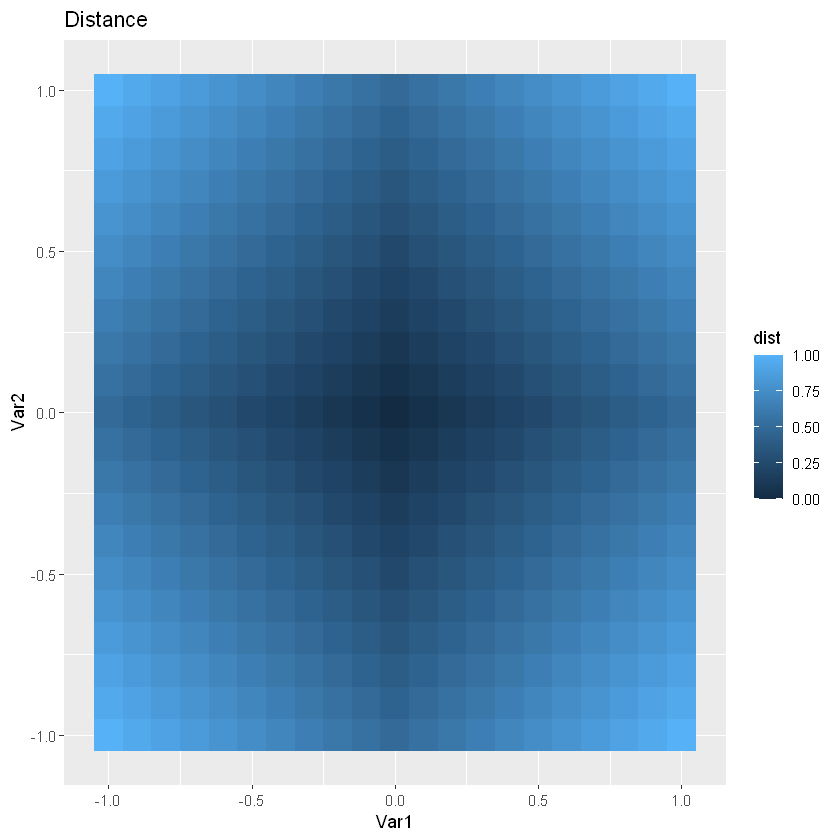

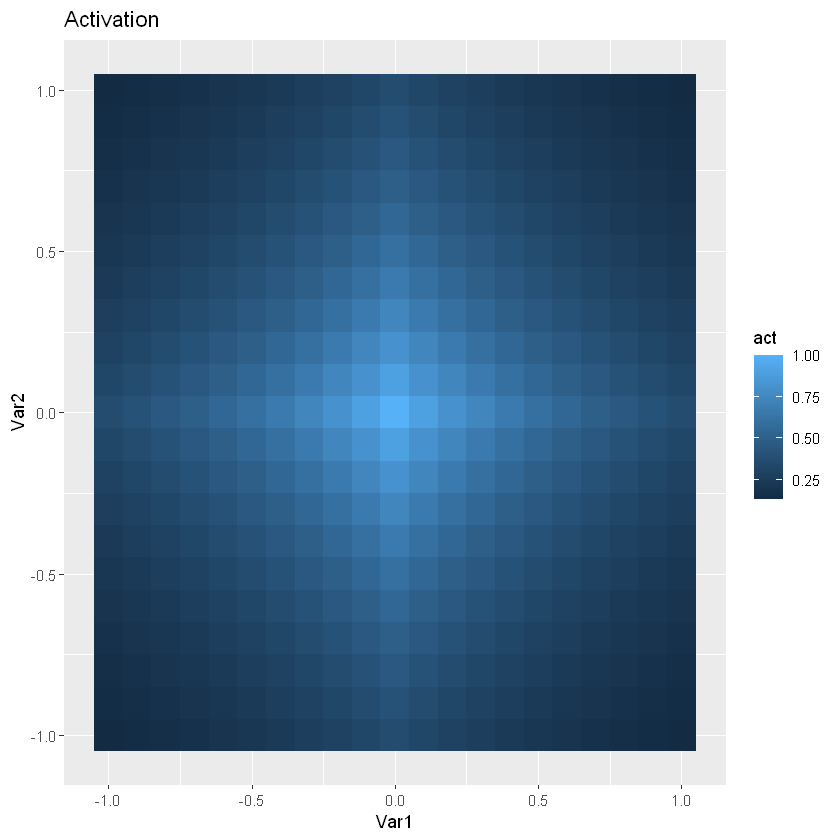

In [17]:

#Visualization of distance and similarity
ps = expand.grid(seq(-1, 1, .1), seq(-1, 1, .1))
ps$dist = apply(ps, 1, function(x) minkdist(x, c(0, 0), w = c(.5, .5), p = 1))
library(ggplot2)
ggplot(ps, aes(x = Var1, y = Var2, fill = dist)) + geom_tile() + labs(title = 'Distance')
ps$act = act(ps$dist, 2)
ggplot(ps, aes(x = Var1, y = Var2, fill = act)) + geom_tile() + labs(title = 'Activation')




<h1 id="Getting-our-first-model-response">Getting our first model response<a class="anchor-link" href="#Getting-our-first-model-response">¶</a></h1><p>Let's use the model, step by step.</p>


In [18]:

#Generate model's responses for the training stimuli
#Define parameters
temp = 2
sens = 1
p = 1
aw = c(.2, .2, .6)

#distance matrix
dist_mat = apply(stims[, 1:3], 1, function(x) apply(stims[, 1:3], 1, function(y) minkdist(x, y, w = aw, p = p)))

#activations
act_mat = apply(dist_mat, 1, function(x) act(x, sens))

#probabilities
p1 = apply(act_mat, 1, function(x) catresp(x, stims$cat, temp))

#Here are the model responses
cbind(truecat = stims$cat, p1, sqerror = (stims$cat-p1)^2)



,truecat,p1,sqerror
1,0,0.1873898,0.03511495
2,0,0.2314752,0.05358078
3,0,0.2314752,0.05358078
6,1,0.7685248,0.05358078
7,1,0.7685248,0.05358078
8,1,0.8126102,0.03511495



<p>So, the model goes through three steps every time a stimulus is shown. First, calculate the distance between what you see, and what you have stored in memory. Then, activate memory. Finally, pool activations to generate a categorical response (i.e. reporting a stimulus as a member of one category, or the other).</p>
<p>Let's create a wrapper function to do all of that with a single call, so we can move to parameter retrieval.</p>


In [19]:

gcm_wrap = function(pars, qs, ms){
  dist_mat = apply(qs[, 1:3], 1, function(x) apply(ms[, 1:3], 1, function(y) minkdist(x, y, w = pars$aw, p = pars$p)))
  act_mat = apply(dist_mat, 1, function(x) act(x, pars$sens))
  p1 = apply(act_mat, 1, function(x) catresp(x, ms$cat, pars$temp))
  return(p1)
}




<p>Were pars is a list of parameters, qs are the queried stimuli, and ms are the stimuli stored in memory.</p>


In [20]:

params = list(temp = 2, sens = 1, p = 1, aw = c(.2, .2, .6))
#wrapper usage
gcm_wrap(params, stims[1:4, ], stims)
#Notice how manipulating the exemplars in memory alters the responses
gcm_wrap(params, stims[1:4, ], stims[1:5, ])



1         2         3         6 
0.1873898 0.2314752 0.2314752 0.7685248

1         2         3         6 
0.1040196 0.1194370 0.1194370 0.5992228


<h1 id="Parameter-recovery">Parameter recovery<a class="anchor-link" href="#Parameter-recovery">¶</a></h1><p>Because we were interested in drawing inferences about the attentional profiles of pigeons and humans, we needed to recover attentional weights from their response data. In order to do that, we need a loss-function that tells us how wrong our model responses are, and a way to optimize it. Let's begin by adding a loss-function to our wrapper.</p>


In [21]:

#First, create a vector of probabilities
realPs = gcm_wrap(params, stims, stims)
#Create a wrapper to optimize only the attentional weights; Note how a lot of things are being defined at this time. Careful!
opt_wrap = function(p, fixedpars, responses){
  fixedpars$aw = p
  modP = gcm_wrap(fixedpars, stims, stims)
  return(sum((modP-responses)^2)) #Returns the sum of squared error by default, but the likelihood function (and -loglik) is a better choice
}
#quick test
opt_wrap(params$aw, params, realPs) #the sum of squared error of a model against itself is 0.
opt_wrap(c(.2, .3, .5), params, realPs) #some error



[1] 0

[1] 0.007225938


<p>For the paper, I used a projection function for the attentional weights, constraining their sums to 1. The implementation of this is not trivial, and can have major consequences during numerical optimization. Fortunately, the BB package allows for the use of projection functions.</p>


In [22]:

#Define the projection function
projWeights = function(p){
  return(p/sum(p))
}
#Fortunately, package BB allows us to use a projection function during optimization
library(BB)
opt = spg(rep(1, 3), function(x) opt_wrap(x, params, realPs), lower = rep(.Machine$double.xmin, 3), project = projWeights, control = list(eps = 1e-1))
opt$par #Very close



Warning message:
"package 'BB' was built under R version 4.2.3"


iter:  0  f-value:  0.09811652  pgrad:  0.08336469 
iter:  10  f-value:  0.001244458  pgrad:  0.0003383161 


[1] 0.2221103 0.2221103 0.5557794


<h1 id="A-problem">A problem<a class="anchor-link" href="#A-problem">¶</a></h1><p>Of course, the mapping between the generative model and the measured data is rarely this good.
Add some normal error to our probabilities and see if we can still retrieve the parameters that generated it. If you are running this in the live version of the notebook, it might take a while to finish.</p>


iter:  0  f-value:  0.1021205  pgrad:  0.1158556 
iter:  10  f-value:  0.03272941  pgrad:  0.05918284 
iter:  20  f-value:  0.009344649  pgrad:  0.04605587 
iter:  30  f-value:  0.01874639  pgrad:  0.1114196 
iter:  40  f-value:  0.008237177  pgrad:  0.674685 
iter:  50  f-value:  0.00114191  pgrad:  1.663208 
iter:  60  f-value:  0.009575693  pgrad:  0.9049957 
iter:  70  f-value:  0.00685325  pgrad:  0.192698 
iter:  80  f-value:  0.0142196  pgrad:  0.07479896 
iter:  90  f-value:  0.008389785  pgrad:  0.0715598 
iter:  100  f-value:  0.003618865  pgrad:  0.5529408 


Warning message in spg(rep(1, 3), function(x) opt_wrap(x, params, addNoise(realPs)), :
"Unsuccessful convergence."


[1] -0.1307526  0.4850010  0.6457516

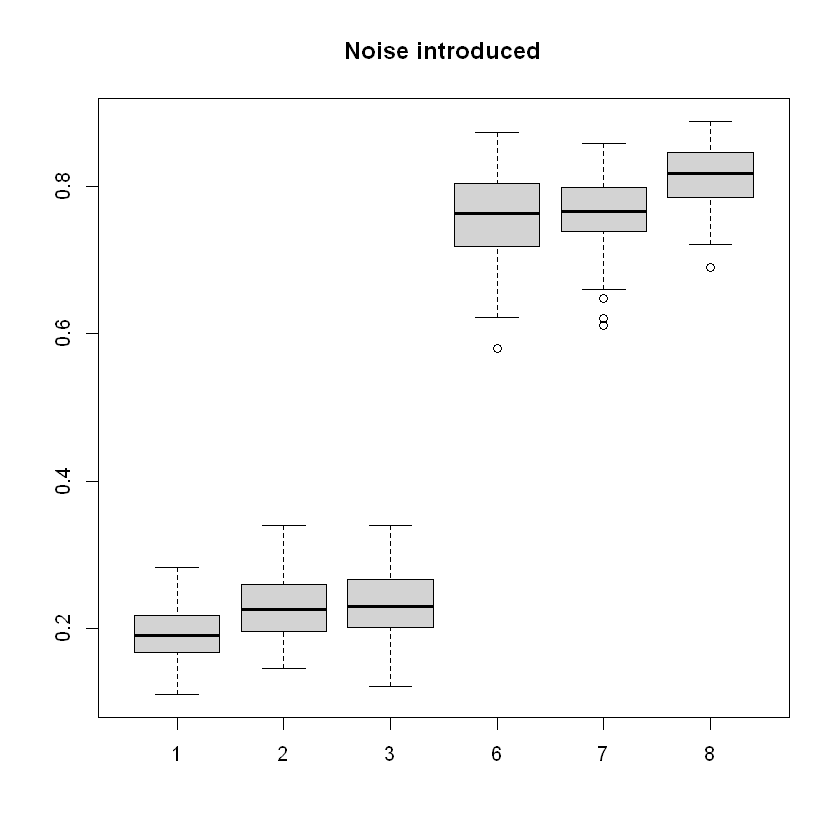

In [23]:

addNoise = function(p, fact = .3){ #convenience function
  return(1/(1+exp(-log(p/(1-p))+rnorm(length(p))*fact)))
}

#Look at how much noise we are introducing
boxplot(t(replicate(100, addNoise(realPs))), main = "Noise introduced") #seems fair

#Just a little bit of noise makes parameter recovery innacurate, of course
opt = spg(rep(1, 3), function(x) opt_wrap(x, params, addNoise(realPs)), lower = rep(.Machine$double.xmin, 3), upper = rep(1, 3), 
          project = projWeights, control = list(eps = 1e-1, maxit = 100))
opt$par #ugh




<p>Convergence is an issue, of course. Don't worry too much about it, however, as you can brute force your way into convergence in one way or another. What should be more worrisome is the fact that even a tiny bit of noisy can throw the optimizer on a loop. Let's fight it with more iterations.</p>


[1] 0.2516715 0.2335617 0.5147669

[1] 0.2619619 0.2429594 0.4971911

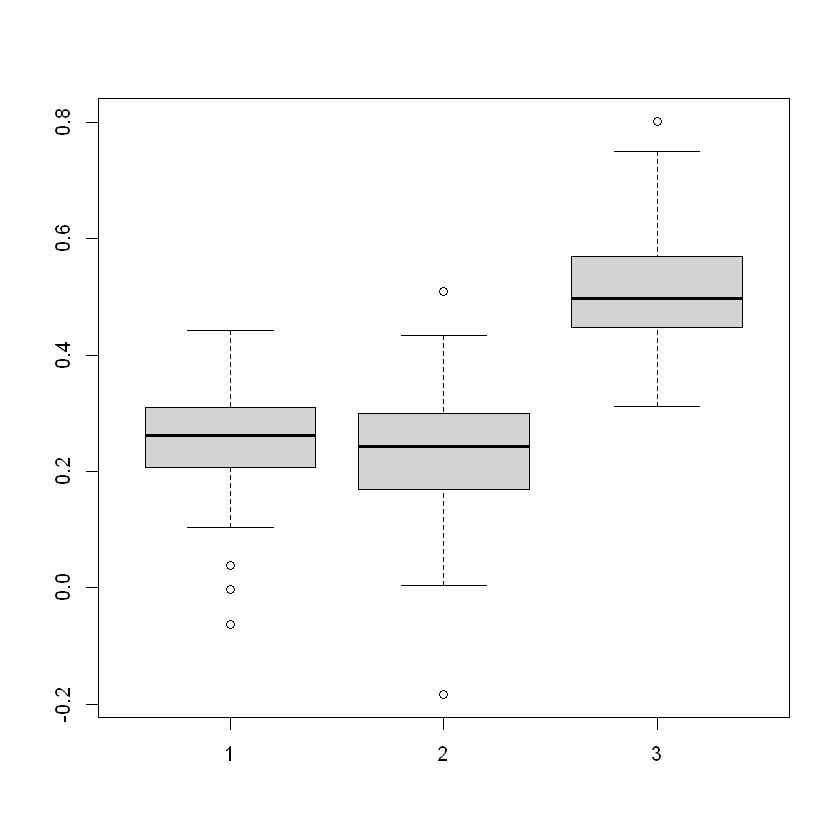

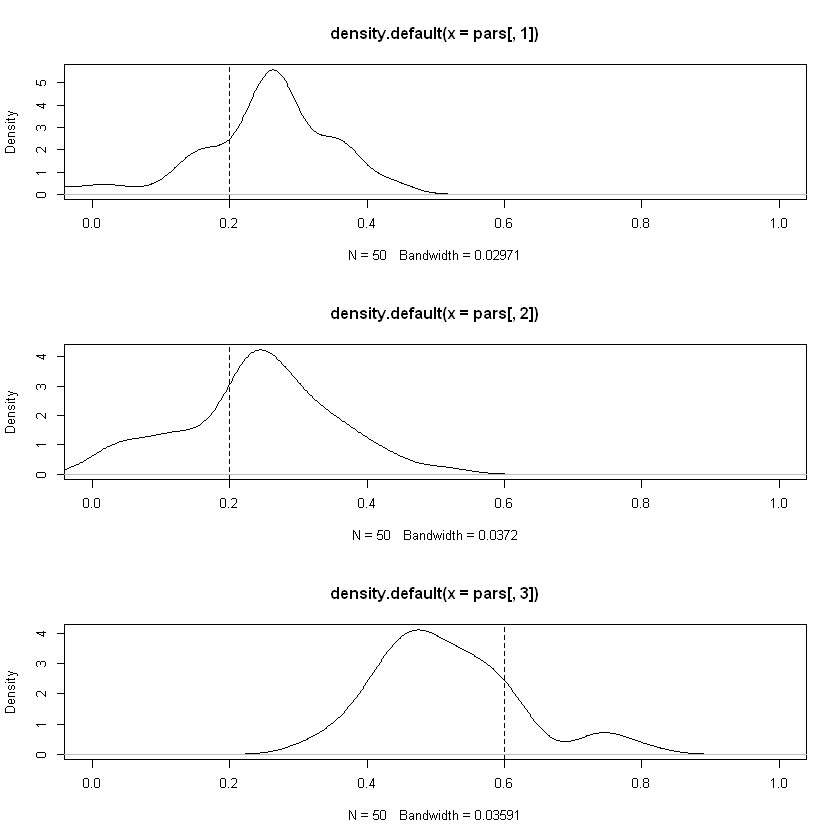

In [24]:

#We can look at the parameters we recover over multiple iterations
iter = 50
pars = array(NA, c(iter, 3))
for (i in 1:iter){
  pars[i, ] = spg(rep(1, 3), function(x) opt_wrap(x, params, addNoise(realPs)), lower = rep(.Machine$double.xmin, 3), upper = rep(1, 3), 
                  project = projWeights, control = list(eps = 1e-1, maxit = 100), quiet = T, alertConvergence = F)$par
} #takes a while to run; very slow implementation; mb
boxplot(pars)
colMeans(pars) #we're not THAT far away from the real parameters
apply(pars, 2, median)
#Take a look at the distributions
op = par(mfrow = c(3, 1))
plot(density(pars[, 1]), xlim = c(0, 1))
abline(v = params$aw[1], lty = 'dashed')
plot(density(pars[, 2]), xlim = c(0, 1))
abline(v = params$aw[2], lty = 'dashed')
plot(density(pars[, 3]), xlim = c(0, 1))
abline(v = params$aw[3], lty = 'dashed')
par(op)
#biased!



[1] 0.9986053

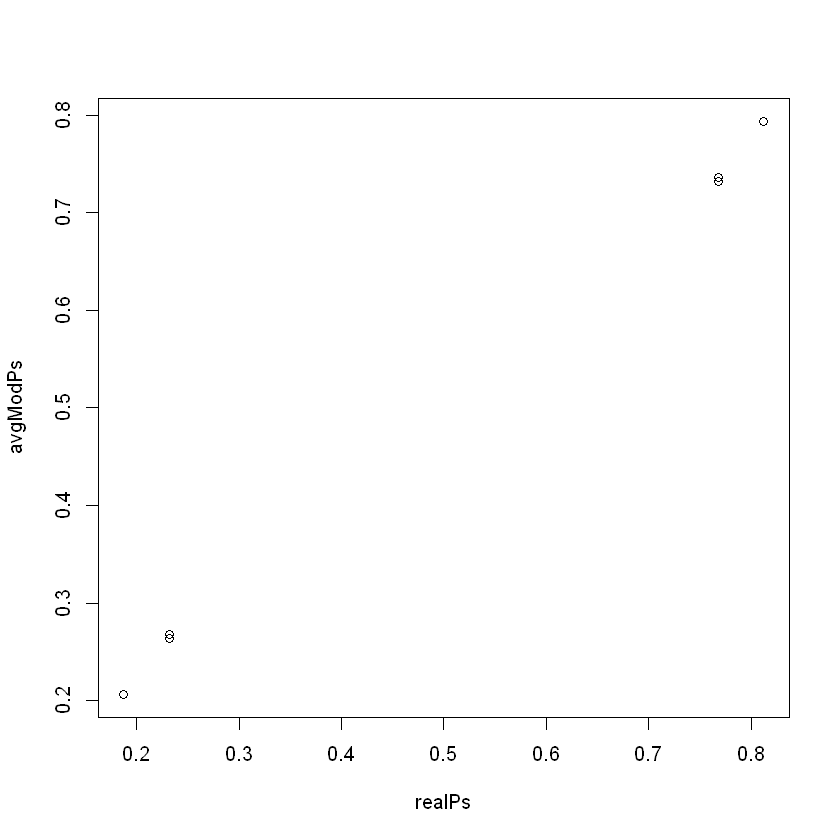

In [25]:

#on average, the model produces pretty good fits
avgModPs = colMeans(t(apply(pars, 1, function(x) gcm_wrap(list(temp = 2, sens = 1, p = 1, aw = x), stims, stims))))
plot(realPs, avgModPs)
cor(realPs, avgModPs)^2




<h1 id="The-biggest-problem">The biggest problem<a class="anchor-link" href="#The-biggest-problem">¶</a></h1><p>Our participants (more often than not) are very good at the simple tasks we give them. This often results in them hitting a performance ceiling. Paremeter-recovery becomes much harder at that point.</p>


In [26]:

#Manipulate sensitivity (emulates memorization)
ceilPars = list(temp = 2, sens = 3, p = 1, aw = c(.2, .2, .6))
ceilPs = gcm_wrap(ceilPars, stims, stims)
ceilPs

#Try to recover parameters
opt = spg(rep(1, 3), function(x) opt_wrap(x, ceilPars, ceilPs), lower = rep(.Machine$double.xmin, 3), upper = rep(1, 3), 
          project = projWeights, control = list(eps = 1e-1))
opt$par #sometimes, it won't even deviate from starting parameters



1          2          3          6          7          8 
0.01200499 0.02659699 0.02659699 0.97340301 0.97340301 0.98799501

iter:  0  f-value:  0.002615156  pgrad:  0.6757483 


Warning message in spg(rep(1, 3), function(x) opt_wrap(x, ceilPars, ceilPs), lower = rep(.Machine$double.xmin, :
"Unsuccessful convergence."


[1] 0.3333333 0.3333333 0.3333333


<h1 id="The-solution-is:-more-data!">The solution is: more data!<a class="anchor-link" href="#The-solution-is:-more-data!">¶</a></h1><p>The problem arises from the fact that the cues are redundant; so there are many parameters that fit saturated choices.
In the actual experiment, we tested participants by removing some cues from the stimuli, in order to observe the influence those cues had. Let's create them here.</p>


In [27]:

noD = stims
noD$Var3 = .5 #This removes the deterministic cue, which conveys perfect information
noP1 = stims
noP1$Var1 = .5 #This removes one of the probabilistic cues
noP2 = stims
noP2$Var2 = .5 #This removes the other
testStims = rbind(noD, noP1, noP2)




<p>And let's see how the model fares with them</p>


In [28]:

testPs = gcm_wrap(ceilPars, testStims, stims)
cbind(testStims, modelP = testPs) #Note how the model is close to chance during noD trials (first 6 probabilities). 
#We specified weights that make the model rely on the deterministic cue.



,Var1,Var2,Var3,cat,modelP
,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,0.0,0.0,0.5,0,0.30781477
2,1.0,0.0,0.5,0,0.50000000
3,0.0,1.0,0.5,0,0.50000000
6,1.0,0.0,0.5,1,0.50000000
7,0.0,1.0,0.5,1,0.50000000
8,1.0,1.0,0.5,1,0.69218523
11,0.5,0.0,0.0,0,0.01817003
21,0.5,0.0,0.0,0,0.01817003
31,0.5,1.0,0.0,0,0.03877788



<p>Let's repeat our parameter-recovery excercise using these new data.</p>


In [29]:

#redefine our wrapper to include the new stimuli
test_wrap = function(p, fixedpars, responses){
  fixedpars$aw = p
  modP = gcm_wrap(fixedpars, testStims, stims)
  return(sum((modP-responses)^2))
}
iter = 50
pars = array(NA, c(iter, 3))
for (i in 1:iter){
  pars[i, ] = spg(rep(1, 3), function(x) test_wrap(x, ceilPars, addNoise(testPs)), lower = rep(.Machine$double.xmin, 3), upper = rep(1, 3), 
                  project = projWeights, control = list(eps = 1e-1, maxit = 100), quiet = T, alertConvergence = F)$par
} #takes a very long time to run; sorry!



[1] 0.1815576 0.1682311 0.6502114

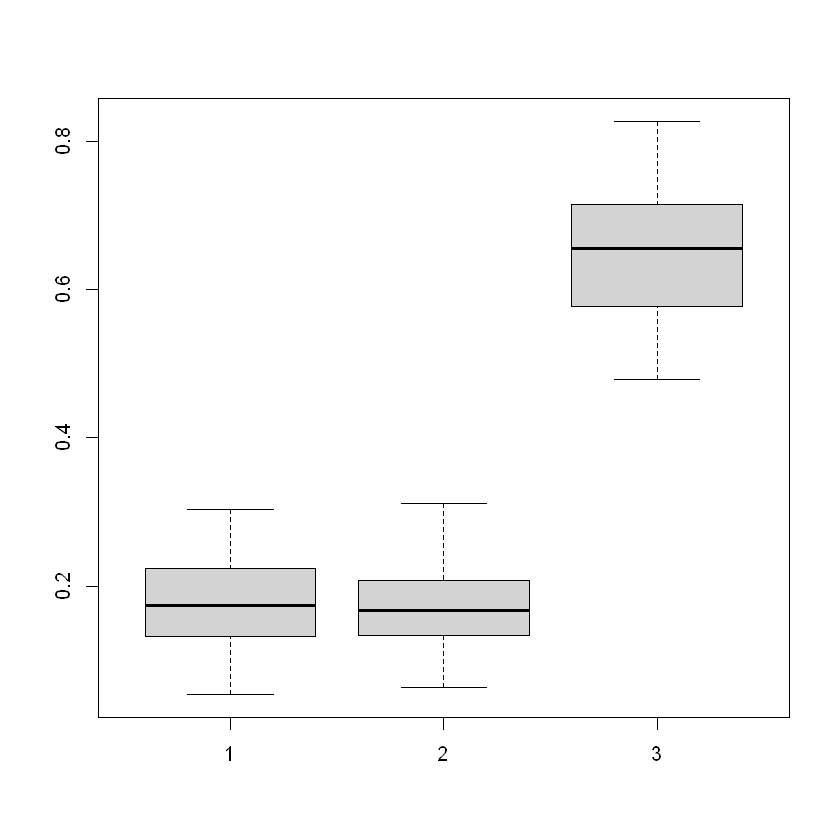

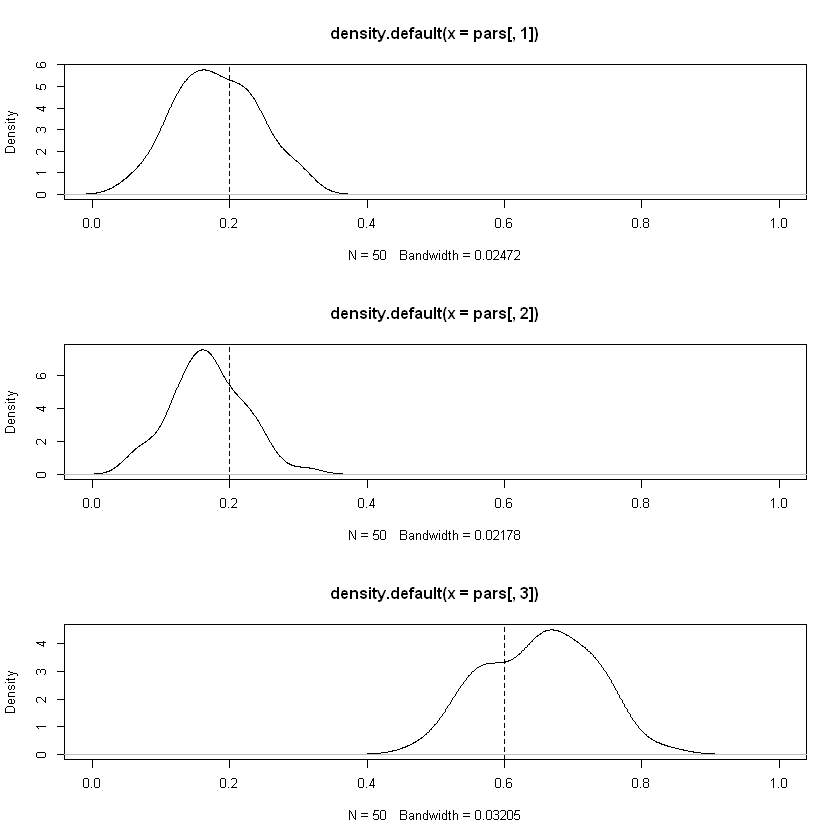

[1] 0.9912765

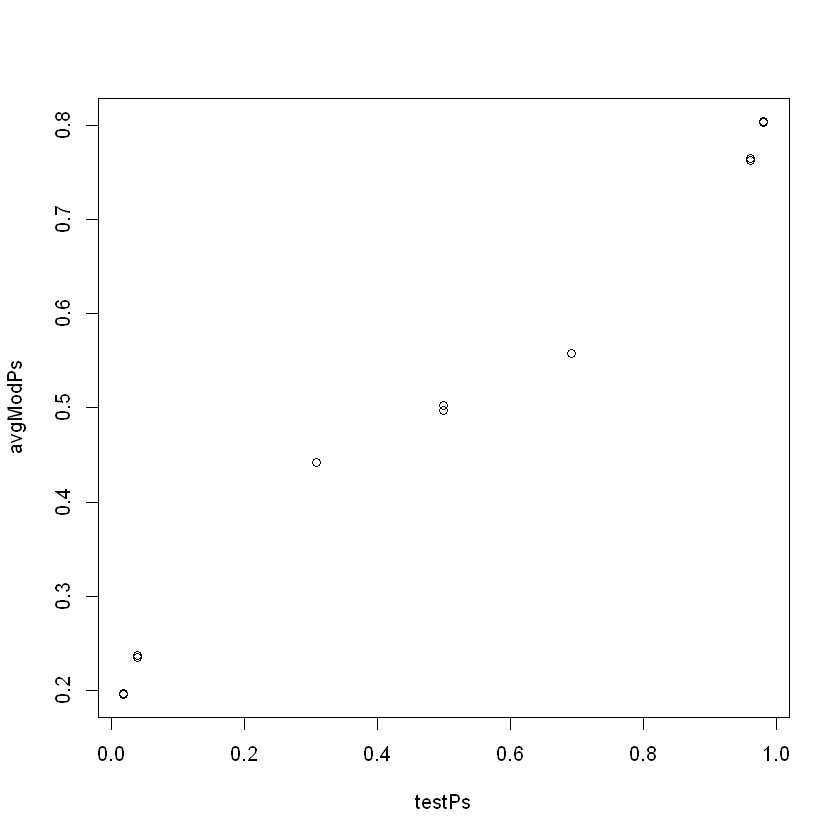

In [30]:

#Let's see the results
boxplot(pars)
colMeans(pars) 
#Take a look at the distributions
op = par(mfrow = c(3, 1))
plot(density(pars[, 1]), xlim = c(0, 1))
abline(v = params$aw[1], lty = 'dashed')
plot(density(pars[, 2]), xlim = c(0, 1))
abline(v = params$aw[2], lty = 'dashed')
plot(density(pars[, 3]), xlim = c(0, 1))
abline(v = params$aw[3], lty = 'dashed')
par(op)

#And the model fit
avgModPs = colMeans(t(apply(pars, 1, function(x) gcm_wrap(list(temp = 2, sens = 1, p = 1, aw = x), testStims, stims))))
plot(testPs, avgModPs)
cor(testPs, avgModPs)^2




<p>A much better recovery, with nearly no bias.</p>



<h1 id="Take-home-message">Take-home message<a class="anchor-link" href="#Take-home-message">¶</a></h1><p>The test data were critical in inferring the attentional profiles of our subjects. There is no modelling trick that can beat a well-designed experiment.</p>
